## Global Feature Importance

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

save_figures = False
figure_path = "../figures/evaluation/"
# df_init = pd.read_parquet("../data/init.parquet")
# df_before = pd.read_parquet("../data/before_split.parquet")
# df_train = pd.read_parquet("../data/prep_train.parquet")
# df_val = pd.read_parquet("../data/prep_val.parquet")
# df_test = pd.read_parquet("../data/prep_test.parquet")
# df_tt_train = pd.read_parquet("../data/prep_tt_train.parquet")
# df_tt_test = pd.read_parquet("../data/prep_tt_test.parquet")
df_all = pd.read_parquet("../data/prep_all.parquet")

In [2]:
df_all.head()

,Year_Y2015,Year_Y2016,Country_England,Country_Wales,Supermarket_Asda,Supermarket_Tesco Extra,Supermarket_Tesco Metro,Supermarket_Waitrose,Time_Evening,Time_Morning,...,YearCountryAge_Y2016EnglandAge_g2,YearCountryAge_Y2016EnglandAge_g3,YearCountryAge_Y2016WalesAge_g1,YearCountryAge_Y2016WalesAge_g2,YearCountryAge_Y2016WalesAge_g3,YearCountryAge_nan,ObsSize,FemaleN,MaleN,y
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.471136,-1.156159,0.871226,1
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.471136,-1.156159,0.871226,1
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.471136,0.583858,-0.993069,1
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.811174,2.323876,-0.993069,1
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.471136,0.583858,-0.993069,1


In [3]:
X_all = df_all.iloc[:,0:-1].to_numpy()
y_all = df_all["y"].to_numpy()

### Measure 2: Tree Impurity

In [4]:
feature_names = df_all.columns[0:-1]

In [5]:
random_state = 132
Dtree = DecisionTreeClassifier()
Ada_grid = AdaBoostClassifier(base_estimator = Dtree, 
                              random_state = random_state)
Ada_grid

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=132)

In [6]:
params_Ada = {'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1],
              'n_estimators': [8, 12, 16, 20, 24, 28, 32, 36, 40],
              'base_estimator__max_depth': [1, 2, 3, 4]}

random_states_split = [123, 456, 789, 
                       741, 852, 963, 
                       159, 753, 951, 357]

gridCV_Ada = GridSearchCV(estimator = Ada_grid, 
                          param_grid = params_Ada, 
                          scoring = 'balanced_accuracy', 
                          n_jobs = -2,
                          refit = True, 
                          cv = 5, verbose = 1)
gridCV_Ada

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=132),
             n_jobs=-2,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4],
                         'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
                                           1.1],
                         'n_estimators': [8, 12, 16, 20, 24, 28, 32, 36, 40]},
             scoring='balanced_accuracy', verbose=1)

In [7]:
%%time

Ada_importances = []

for each_rs in random_states_split:
    start_time = time.time()
    X_other_temp, X_test_temp, y_other_temp, y_test_temp = \
        train_test_split(X_all, y_all, 
                         test_size = 0.1, 
                         random_state = each_rs, 
                         stratify = y_all)
    
    n_each_class = [np.sum(y_other_temp == each_c) 
                    for each_c 
                    in np.unique(y_other_temp)]
    weight_each_class = [1/each_n 
                         for each_n 
                         in n_each_class]
    balanced_weights = np.array([weight_each_class[each_y] 
                                 for each_y 
                                 in y_other_temp])
    
    
    gridCV_Ada.fit(X_other_temp, y_other_temp, 
                   groups = None, 
                   sample_weight = balanced_weights)
    
    Ada_importances.append(gridCV_Ada.best_estimator_.feature_importances_)
    
    print(gridCV_Ada.best_params_, flush = True)
    
    end_time = time.time()
    print(f"Iteration {each_rs}: {end_time - start_time:.3f} seconds", flush = True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 1, 'n_estimators': 16}
Iteration 123: 40.861 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.3, 'n_estimators': 36}
Iteration 456: 39.786 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 2, 'learning_rate': 0.6, 'n_estimators': 24}
Iteration 789: 40.849 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.4, 'n_estimators': 36}
Iteration 741: 40.753 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.8, 'n_estimators': 12}
Iteration 852: 40.868 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.7, 'n_estimators': 16}
Iteration 963: 42.

In [8]:
Ada_importances_array = np.array(Ada_importances)
Ada_importances_array.shape

(10, 85)

In [9]:
Ada_df = pd.DataFrame(data = Ada_importances_array, 
                            columns = feature_names)
Ada_df = pd.concat([Ada_df, 
                    Ada_df.agg(["mean", "std"])])
Ada_df

,Year_Y2015,Year_Y2016,Country_England,Country_Wales,Supermarket_Asda,Supermarket_Tesco Extra,Supermarket_Tesco Metro,Supermarket_Waitrose,Time_Evening,Time_Morning,...,YearCountryAge_Y2016EnglandAge_g1,YearCountryAge_Y2016EnglandAge_g2,YearCountryAge_Y2016EnglandAge_g3,YearCountryAge_Y2016WalesAge_g1,YearCountryAge_Y2016WalesAge_g2,YearCountryAge_Y2016WalesAge_g3,YearCountryAge_nan,ObsSize,FemaleN,MaleN
0,0.000000,0.000000,0.0,0.000000,0.062500,0.0,0.0,0.000000,0.062500,0.000000,...,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,0.000000
1,0.000000,0.000000,0.0,0.000000,0.055556,0.0,0.0,0.000000,0.000000,0.027778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.027778,0.055556,0.000000
2,0.000000,0.000000,0.0,0.000000,0.027456,0.0,0.0,0.000000,0.006717,0.005253,...,0.010636,0.000000,0.000000,0.000000,0.000000,0.053124,0.012575,0.017609,0.054495,0.037297
3,0.000000,0.000000,0.0,0.000000,0.027778,0.0,0.0,0.000000,0.027778,0.000000,...,0.000000,0.027778,0.000000,0.000000,0.000000,0.055556,0.000000,0.027778,0.055556,0.000000
4,0.000000,0.000000,0.0,0.083333,0.083333,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000
5,0.000000,0.000000,0.0,0.000000,0.062500,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000
6,0.000000,0.000000,0.0,0.000000,0.041667,0.0,0.0,0.041667,0.000000,0.000000,...,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.041667,0.041667,0.000000
7,0.000000,0.000000,0.0,0.000000,0.035714,0.0,0.0,0.000000,0.035714,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.035714,0.071429,0.000000
8,0.021941,0.002425,0.0,0.000000,0.016008,0.0,0.0,0.004207,0.000000,0.010285,...,0.004800,0.000000,0.000000,0.034231,0.012190,0.020823,0.000000,0.055485,0.039981,0.039872
9,0.000000,0.000000,0.0,0.000000,0.035714,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.035714,0.035714,0.000000


In [10]:
Ada_df_transposed = Ada_df.T
Ada_df_transposed["abs_mean"] = Ada_df_transposed["mean"].abs()
Ada_df_transposed = Ada_df_transposed\
                        .sort_values(by = "abs_mean", 
                                     ascending = False, 
                                     ignore_index = False)
Ada_df_transposed

,0,1,2,3,4,5,6,7,8,9,mean,std,abs_mean
YearCountry_Y2015England,0.0625,0.138889,0.052379,0.111111,0.083333,0.1250,0.041667,0.071429,0.106361,0.035714,0.082838,0.035993,0.082838
Gender_Male,0.0625,0.083333,0.029941,0.083333,0.083333,0.0625,0.041667,0.071429,0.032501,0.035714,0.058625,0.021968,0.058625
FemaleN,0.0625,0.055556,0.054495,0.055556,0.083333,0.0625,0.041667,0.071429,0.039981,0.035714,0.056273,0.014701,0.056273
Age_Age_g1,0.0625,0.055556,0.040930,0.027778,0.083333,0.0625,0.041667,0.035714,0.008877,0.035714,0.045457,0.021063,0.045457
YearCountryTime_Y2015WalesMorning,0.0000,0.055556,0.022932,0.055556,0.083333,0.0625,0.041667,0.071429,0.024933,0.035714,0.045362,0.025183,0.045362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
YearCountryGender_nan,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YearCountryGender_Y2015EnglandFemale,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YearCountryGender_Y2015EnglandMale,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YearCountrySupermarket_Y2015EnglandTesco Metro,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
Ada_df_transposed = Ada_df_transposed.drop(columns = ["mean", "std", "abs_mean"])
Ada_df_ordered = Ada_df_transposed.T
Ada_df_ordered

,YearCountry_Y2015England,Gender_Male,FemaleN,Age_Age_g1,YearCountryTime_Y2015WalesMorning,Supermarket_Asda,Age_Age_g3,YearCountryTime_Y2016WalesSatMorning,YearCountrySupermarket_Y2015WalesAsda,YearCountryAge_Y2016WalesAge_g3,...,YearCountrySupermarket_Y2016WalesTesco Metro,YearCountryAge_Y2015WalesAge_g1,YearCountrySupermarket_Y2016WalesWaitrose,Gender_Female,Gender_nan,YearCountryGender_nan,YearCountryGender_Y2015EnglandFemale,YearCountryGender_Y2015EnglandMale,YearCountrySupermarket_Y2015EnglandTesco Metro,YearCountryGender_Y2016EnglandMale
0,0.062500,0.062500,0.062500,0.062500,0.000000,0.062500,0.062500,0.000000,0.062500,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.138889,0.083333,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.027778,0.055556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.052379,0.029941,0.054495,0.040930,0.022932,0.027456,0.013344,0.015735,0.023313,0.053124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.111111,0.083333,0.055556,0.027778,0.055556,0.027778,0.055556,0.055556,0.027778,0.055556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.125000,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.000000,0.041667,0.041667,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.071429,0.071429,0.071429,0.035714,0.071429,0.035714,0.035714,0.035714,0.035714,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.106361,0.032501,0.039981,0.008877,0.024933,0.016008,0.017235,0.020368,0.000000,0.020823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


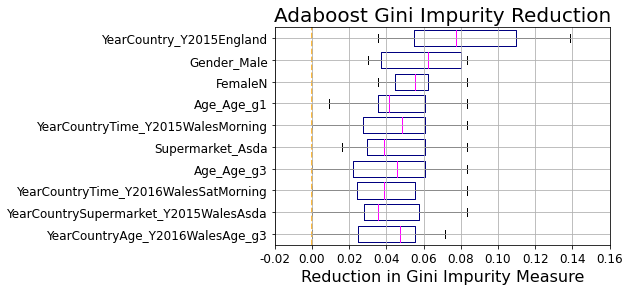

In [16]:
fig_box_ada_top10, ax_box_ada_top10 = plt.subplots()

Ada_df_top10 = Ada_df_ordered.iloc[:, 9::-1]
Ada_df_top10.boxplot(ax = ax_box_ada_top10, 
                     widths = 0.75,
                     boxprops = {'color':'navy'}, 
                     medianprops = {'color':'magenta'}, 
                     whiskerprops = {'color':'black'}, 
                     vert = False, 
                     zorder = -1)

ax_box_ada_top10.set_xticks(ax_box_ada_top10.get_xticks())
ax_box_ada_top10.set_yticks(ax_box_ada_top10.get_yticks())

xticks_ada_top10 = ax_box_ada_top10.get_xticks()
xticklabels_ada_top10 = [f"{x:.2f}" for x in xticks_ada_top10]

ax_box_ada_top10.set_xticklabels(xticklabels_ada_top10, fontsize = 12)
ax_box_ada_top10.set_yticklabels(ax_box_ada_top10.get_yticklabels(), fontsize = 12)

ax_box_ada_top10.set_xlabel("Reduction in Gini Impurity Measure", 
                            fontsize = 16) 
#ax_box_ada_top10.set_ylabel("Feature Importance", fontsize = 12)
ax_box_ada_top10.set_title("Adaboost Gini Impurity Reduction", fontsize = 20)

ax_box_ada_top10.axvline(x = 0, 
                         color = "orange", 
                         linestyle = "dashed", 
                         zorder = 1)

fig_box_ada_top10.set_size_inches([6, 4])

# save_figures
if save_figures:
    fig_name = f"{figure_path}Adaboost Gini Impurity Top 10"
    fig_box_ada_top10.savefig(f"{fig_name}.pdf", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_ada_top10.savefig(f"{fig_name}.png", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_ada_top10.savefig(f"{fig_name}.svg", 
                              dpi = 300, 
                              bbox_inches="tight")

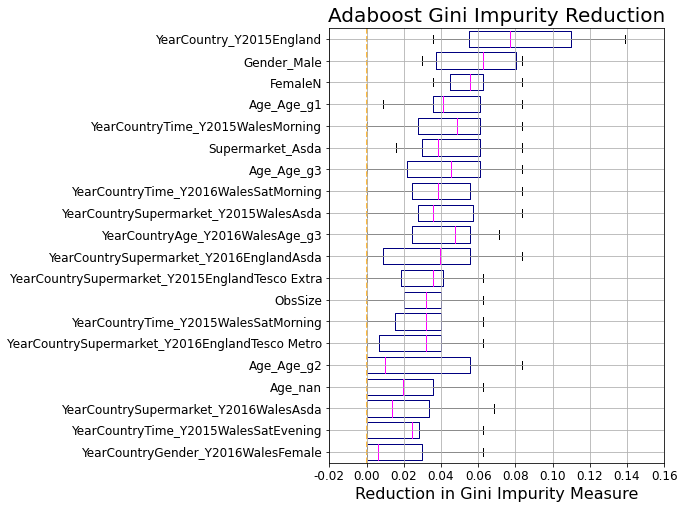

In [17]:
fig_box_ada_top20, ax_box_ada_top20 = plt.subplots()

Ada_df_top20 = Ada_df_ordered.iloc[:, 19::-1]
Ada_df_top20.boxplot(ax = ax_box_ada_top20, 
                     widths = 0.75,
                     boxprops = {'color':'navy'}, 
                     medianprops = {'color':'magenta'}, 
                     whiskerprops = {'color':'black'}, 
                     vert = False, 
                     zorder = -1)

ax_box_ada_top20.set_xticks(ax_box_ada_top20.get_xticks())
ax_box_ada_top20.set_yticks(ax_box_ada_top20.get_yticks())

xticks_ada_top20 = ax_box_ada_top20.get_xticks()
xticklabels_ada_top20 = [f"{x:.2f}" for x in xticks_ada_top20]

ax_box_ada_top20.set_xticklabels(xticklabels_ada_top20, fontsize = 12)
ax_box_ada_top20.set_yticklabels(ax_box_ada_top20.get_yticklabels(), fontsize = 12)

ax_box_ada_top20.set_xlabel("Reduction in Gini Impurity Measure", 
                            fontsize = 16) 
#ax_box_ada_top20.set_ylabel("Feature Importance", fontsize = 12)
ax_box_ada_top20.set_title("Adaboost Gini Impurity Reduction", fontsize = 20)

ax_box_ada_top20.axvline(x = 0, 
                         color = "orange", 
                         linestyle = "dashed", 
                         zorder = 1)

fig_box_ada_top20.set_size_inches([6, 8])

# save_figures
if save_figures:
    fig_name = f"{figure_path}Adaboost Gini Impurity Top 20"
    fig_box_ada_top20.savefig(f"{fig_name}.pdf", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_ada_top20.savefig(f"{fig_name}.png", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_ada_top20.savefig(f"{fig_name}.svg", 
                              dpi = 300, 
                              bbox_inches="tight")

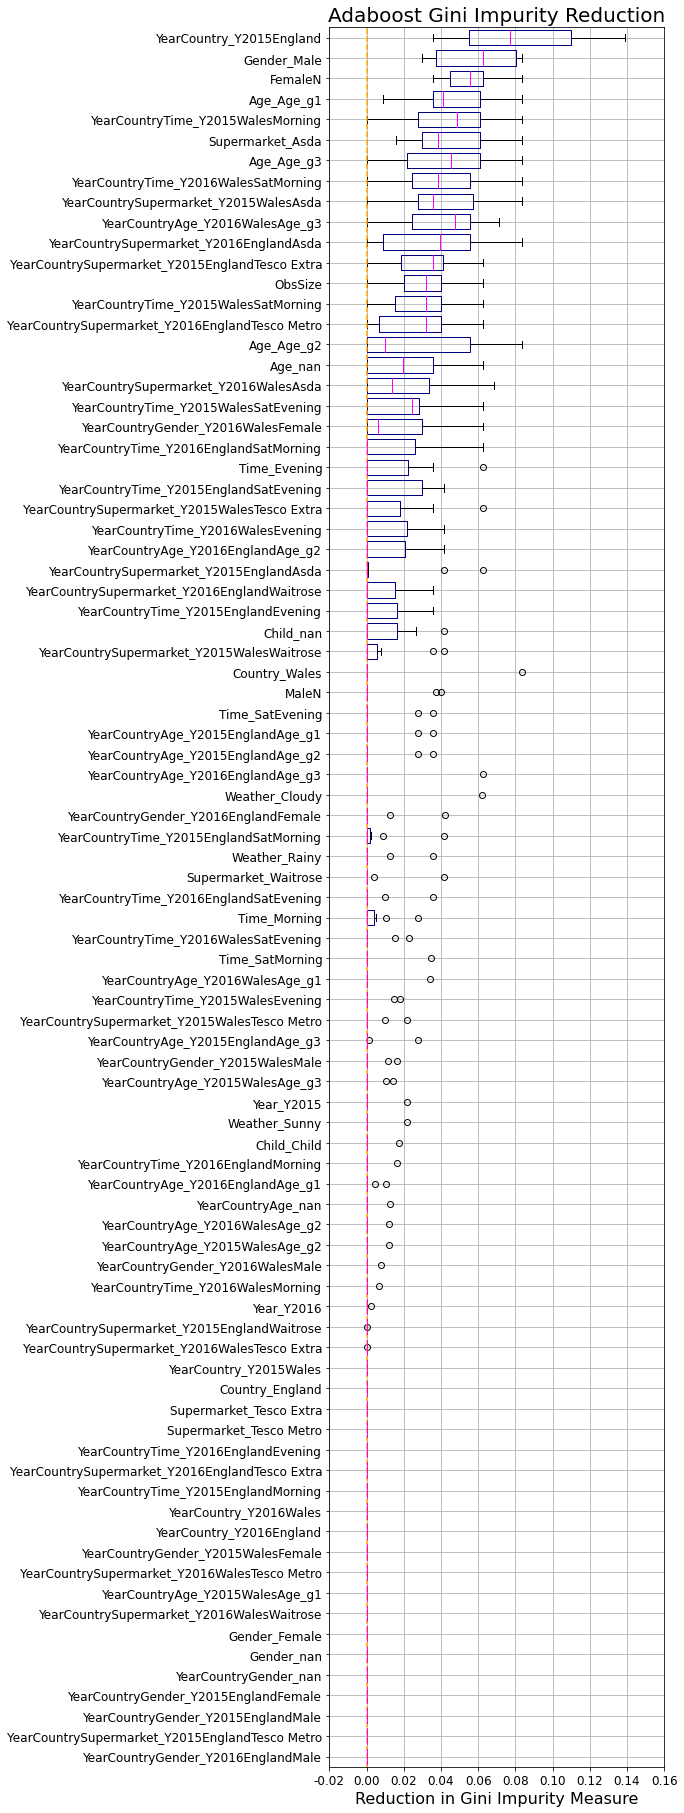

In [21]:
fig_box_ada_all85, ax_box_ada_all85 = plt.subplots()

Ada_df_all85 = Ada_df_ordered.iloc[:, ::-1]
Ada_df_all85.boxplot(ax = ax_box_ada_all85, 
                     widths = 0.75,
                     boxprops = {'color':'navy'}, 
                     medianprops = {'color':'magenta'}, 
                     whiskerprops = {'color':'black'}, 
                     vert = False)

ax_box_ada_all85.set_xticks(ax_box_ada_all85.get_xticks())
ax_box_ada_all85.set_yticks(ax_box_ada_all85.get_yticks())

xticks_ada_all85 = ax_box_ada_all85.get_xticks()
xticklabels_ada_all85 = [f"{x:.2f}" for x in xticks_ada_all85]

ax_box_ada_all85.set_xticklabels(xticklabels_ada_all85, fontsize = 12)
ax_box_ada_all85.set_yticklabels(ax_box_ada_all85.get_yticklabels(), fontsize = 12)

ax_box_ada_all85.set_xlabel("Reduction in Gini Impurity Measure", 
                            fontsize = 16) 
#ax_box_ada_all85.set_ylabel("Feature Importance", fontsize = 12)
ax_box_ada_all85.set_title("Adaboost Gini Impurity Reduction", fontsize = 20)

ax_box_ada_all85.axvline(x = 0, 
                         color = "orange", 
                         linestyle = "dashed")

fig_box_ada_all85.set_size_inches([6, 32])

# save_figures
if save_figures:
    fig_name = f"{figure_path}Adaboost Gini Impurity All 85"
    fig_box_ada_all85.savefig(f"{fig_name}.pdf", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_ada_all85.savefig(f"{fig_name}.png", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_ada_all85.savefig(f"{fig_name}.svg", 
                              dpi = 300, 
                              bbox_inches="tight")